# Causal Data Science Week 3 Tutorial

In this tutorial, we will cover how to identify estimands in your causal graph. We will first apply the backdoor, instrumental variable, and frontdoor criterions manually to identify the estimands. We will then look at how DoWhy can do this for you automatically.

### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backdoor' paths from the treatment variable.

Given a CBN $(G = (\mathbf{V}, \mathbf{E}), p)$ and a distinct pair of variables $X_i, Y_j \in \mathbf{V}$, a set $\mathbf{Z} \subseteq \mathbf{V} \setminus \{i,j\}$ satisfies the
**backdoor criterion** for estimating the causal effect of $X_i$ on $X_j$ if:
- $\mathbf{Z}$ does not contain any descendant of $i$, $Desc(i) \cap \mathbf{Z} = \emptyset$, **and**
- $\mathbf{Z}$ blocks all backdoor paths from $i$ to $j$ (all paths that start with an arrow into $i \gets ... j$)

The example below is taken from: https://medium.data4sci.com/causal-inference-part-xi-backdoor-criterion-e29627a1da0e. To make the examples more clear, instead of using indices we will use capital letters to denote both the variables and their corresponding vertices in the causal graph.

Let's create a network and manually identify adjustment sets based on the backdoor criterion. We want to find effect of $X$ on $Y$.

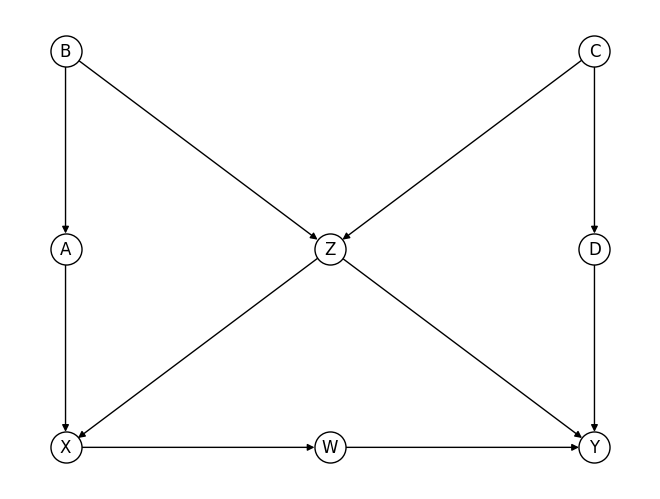

In [3]:
# we import networkx and create a directed graph
import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(['A', 'B', 'C', 'D', 'W', 'X', 'Y', 'Z'])

G.add_edges_from([('B','A'), ('B','Z'), ('C','Z'), ('C','D'), 
                  ('A','X'), ('Z','X'), ('Z','Y'), ('D','Y'),
                 ('X','W'), ('W','Y')])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear) 
# and save it to a .gml format (for using DoWhy later)
pos = {'B': (-1, 1),              'C': (1, 1),
         'A': (-1, 0), 'Z': (0, 0), 'D': (1, 0),
         'X': (-1, -1), 'W': (0, -1), 'Y': (1, -1),}
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors ='black')
nx.write_gml(G, "backdoor_criterion_graph.gml")

We can start by identifying the descendants of $X$, as these must <u>not</u> be in our adjustment set according to the backdoor criterion. The descendants of $X$ are: $X$, $W$, and $Y$.

In [28]:
# this function finds the descendants of node 'X' in graph G
# note that in this function does not return 'X' as a descendant of 'X' - this is not the definition we use, so we add 'X'
nx.descendants(G,'X') | {'X'}

{'W', 'Y'}

We now consider every backdoor path from $X$ to $Y$, and find the variables for which we can/must adjust. We start off by importing the 'backdoor' class from DoWhy.

In [5]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

e:\Users\Linuxer\miniconda3\envs\causal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we create an undirected copy of our graph and call it $H$ so we can find all possible undirected paths between $X$ and $Y$.

In [6]:
# creating a copy of our graph G that is undirected
H = G.to_undirected()

In [7]:
# the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
all_possible_paths = list(nx.all_simple_paths(H, 'X', 'Y'))
for path in all_possible_paths:
    print(path)

['X', 'A', 'B', 'Z', 'C', 'D', 'Y']
['X', 'A', 'B', 'Z', 'Y']
['X', 'W', 'Y']
['X', 'Z', 'C', 'D', 'Y']
['X', 'Z', 'Y']


Finally, we can use the `is_backdoor` method of a `Backdoor` instance to check which of these paths are backdoor paths.

In [29]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(G, 'X', 'Y')

In [9]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

['X', 'A', 'B', 'Z', 'C', 'D', 'Y']
['X', 'A', 'B', 'Z', 'Y']
['X', 'Z', 'C', 'D', 'Y']
['X', 'Z', 'Y']


Now we can find possible adjustment sets for each of these paths.

In [30]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
import pandas as pd
import numpy as np

adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])
adjustment_variables

,path,colliders,non_colliders


The first path we consider is $X <- A <- B -> Z <- C -> D - > Y$.

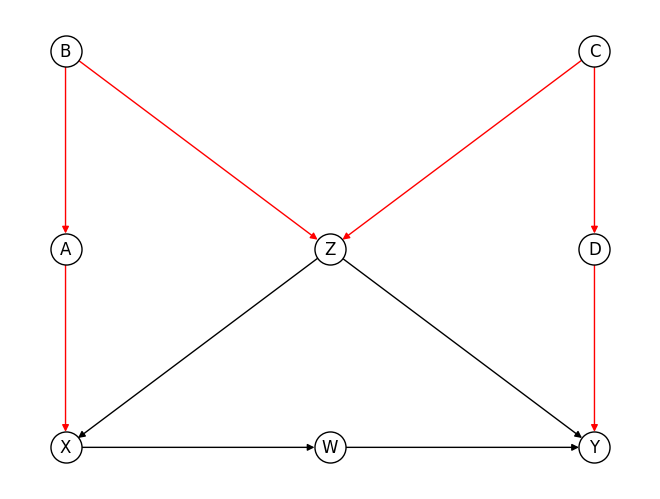

In [11]:
colors = ['r', 'r', 'r', 'r', 'r', 'r', 'black', 'black', 'black', 'black']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [31]:
# this is the path we are testing
path = ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']

In [38]:
# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

In [39]:
# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()

In [40]:
colliders

array(['X', 'W', 'Y', 'Z'], dtype='<U32')

In [34]:
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

In [16]:
# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

In [17]:
adjustment_variables

,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[X, W, Y, Z]","[A, B, C, D]"


We now can see that we need either:

1. Not to condition on $Z$ or its descendants ($Y$, $W$, $X$), or
2. Condition on at least one of $A$, $B$, $C$, $D$

The second path we consider is $X <- A <- B -> Z - > Y$.

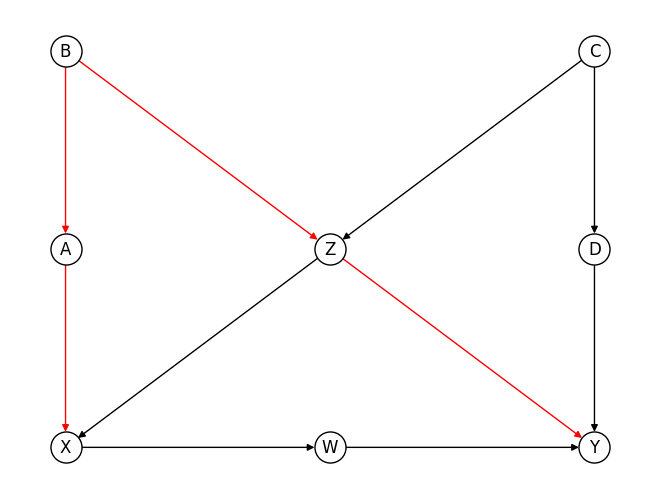

In [18]:
colors = ['r', 'r', 'r', 'black', 'black', 'black', 'black', 'black', 'black', 'r']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [19]:
# this is the path we are testing
path = ['X', 'A', 'B', 'Z', 'Y']

# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()
        
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

adjustment_variables

,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[X, W, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"


 There are no colliders on this path, so we need to condition on at least one of $A$, $B$, or $Z$.

The third path is $X <- Z - > Y$.

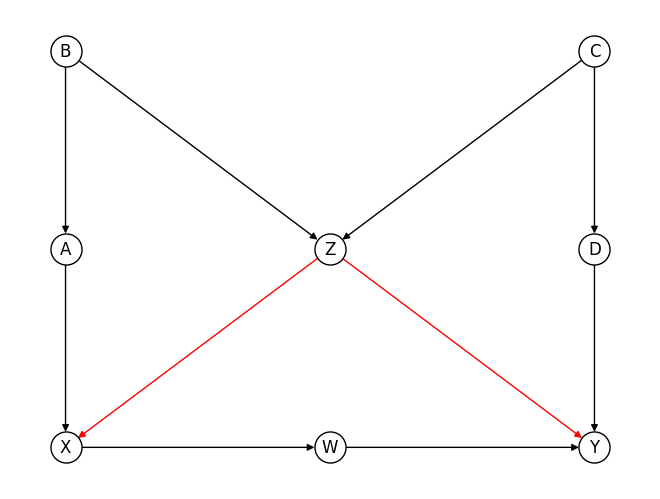

In [20]:
colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'r', 'r']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [21]:
# this is the path we are testing
path = ['X', 'Z', 'Y']

# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()
        
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

adjustment_variables

,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[X, W, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"
2,"[X, Z, Y]",[],[Z]


 There are no colliders on this path, so we need to condition on the one remaining variable, $Z$.

The final path is $X <- Z <- C -> D -> Y$. 

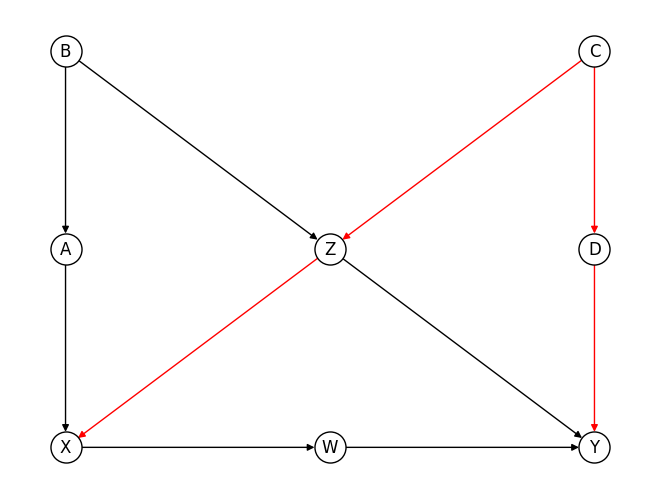

In [22]:
colors = ['black', 'black', 'black', 'r', 'r', 'r', 'black', 'black', 'r', 'black']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [23]:
# this is the path we are testing
path = ['X', 'Z', 'C', 'D', 'Y']

# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()
        
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders]

adjustment_variables

,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[X, W, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"
2,"[X, Z, Y]",[],[Z]
3,"[X, Z, C, D, Y]",[],"[Z, C, D]"


Once again, there are no colliders on this path, so we have to condition on at least one of $C$, $D$, or $Z$. 

Combining all conditions together, we have the following:

1. Not condition on $Z$ and its decendants ($Y$) OR condition on at least one of $A$, $B$, $C$, $D$
2. Condition on at least one of $A$, $B$, or $Z$
3. Condition on $Z$
4. Condition on at least one of $C$, $D$, or $Z$

So we need to condition on $Z$. This then satisfies conditions 2, 3, and 4. To satisfy 1, we now need to condition on at least one of $A$, $B$, $C$, or $D$. Thus, our possible sets are: {$Z$, $A$}, {$Z$, $B$}, ..., {$Z$, $A$, $B$, $C$, $D$}.

In [24]:
adjustment_variables

,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[X, W, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"
2,"[X, Z, Y]",[],[Z]
3,"[X, Z, C, D, Y]",[],"[Z, C, D]"


DoWhy can find sets satisfying the backdoor criterion automatically. We simply provide it with the graph (in .gml format). We also need to provide it with data, but since we are only worried about the backdoor criterion for now, we can give it meaningless data (remember: the estimands are graph-specific, and don't rely on the data).

graph [  directed 1  node [    id 0    label "A"  ]  node [    id 1    label "B"  ]  node [    id 2    label "C"  ]  node [    id 3    label "D"  ]  node [    id 4    label "W"  ]  node [    id 5    label "X"  ]  node [    id 6    label "Y"  ]  node [    id 7    label "Z"  ]  edge [    source 0    target 5  ]  edge [    source 1    target 0  ]  edge [    source 1    target 7  ]  edge [    source 2    target 7  ]  edge [    source 2    target 3  ]  edge [    source 3    target 6  ]  edge [    source 4    target 6  ]  edge [    source 5    target 4  ]  edge [    source 7    target 5  ]  edge [    source 7    target 6  ]]


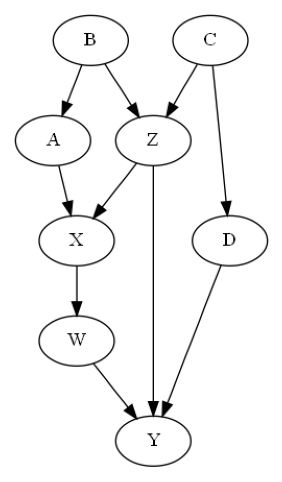

In [42]:
import dowhy
from dowhy import CausalModel

# creating arbitrary data
df = pd.DataFrame({'A':[1],'B':[1],'C':[1],'D':[1],'W':[1],'X':[1],
                  'Y': [1], 'Z': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
print(gml_graph)
# With GML string
model=CausalModel(
    data = df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)
model.view_model()

In [41]:
df

,A,B,C,D,W,X,Y,Z
0,1,1,1,1,1,1,1,1


In [26]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d            
────(E[Y|Z,B])
d[X]          
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,B,U) = P(Y|X,Z,B)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([W])⎥
 ⎣d[W]    d[X]     ⎦
Estimand assumption 1, Full-mediation: W intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{W} then P(W|X,U) = P(W|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{W} and U→Y then P(Y|W, X, U) = P(Y|W, X)



Under Estimand 1, we can see the adjustment set identified by DoWhy. This set will be one of those we manually found, but can differ from run to run.

DoWhy's code for finding the backdoor criterion sets is available at: https://github.com/microsoft/dowhy/blob/master/dowhy/causal_identifiers/backdoor.py. You can look into this a bit if you want to understand better how DoWhy finds the adjustment sets. For example, you can access all the minimum-sized and maximum-sized adjustment sets as follows:

In [27]:
identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, model._graph.get_all_nodes())

[{'backdoor_set': ('A', 'C', 'Z', 'B', 'D')},
 {'backdoor_set': ('A', 'Z')},
 {'backdoor_set': ('C', 'Z')},
 {'backdoor_set': ('Z', 'B')},
 {'backdoor_set': ('Z', 'D')}]